<a href="https://colab.research.google.com/github/mano3-1/CovidNet/blob/master/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

JUST RUN THE CELL. IT WILL AUTOMATICALY DOWNLOAD THE MODELS.
JUST UPLOAD THE X RAY IMAGE(S) WHEN THE PROMPT APPEARS IN THE OUTPUT BY CLICKING ON THE UPLOAD BUTTON .YOU CAN RE-RUN THE CELLS FOR TESTING IT ON NEW IMAGES.
(MODELS ARE ONLY DOWNOLADED ONCE OR WHEN THE RUNTIME GETS CONNECTED TO A NEW SYSTEM, THIS IS DONE AUTOMATICALLY) 

MODELS FOLDER FOUND!
/content/inputs


Saving covid.jpeg to covid.jpeg
Saving normal.jpeg to normal.jpeg
User uploaded file "covid.jpeg" with length 37024 bytes
User uploaded file "normal.jpeg" with length 33928 bytes
/content
GIVING RESULTS..
____________________________________________________________________________________________________
result for  covid.jpeg
image size being used is (224, 224)
result is covid


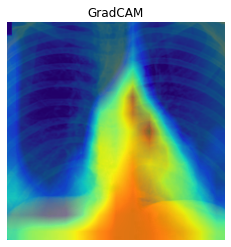

____________________________________________________________________________________________________
result for  normal.jpeg
image size being used is (224, 224)
result is covid


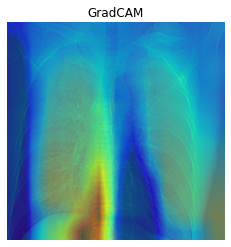

In [2]:
import os
from google.colab import files
import os
import keras
from keras.models import Model ,load_model
import numpy
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import keras.backend as K
def get_result(file ,BB_model = '/content/models/BB.h5' ,
               main_model = '/content/models/classification.h5'):
    def preprocess_BB(img):
        return ((img/255)-0.5)*2
    def loss(y_true ,y_pred):
        return K.sum(K.square(y_true-y_pred))**2
    def crop(prediction ,img ,epsilon = 0.2):
        k = prediction[0]*224
        k1 = [min(k[0] ,k[4])*(1-epsilon) ,min(k[1] ,k[5])*(1-epsilon) ,
              max(k[2]+k[0] ,k[6]+k[4])*(1+epsilon) ,max(k[3]+k[1] ,k[7]+k[5])*(1+epsilon)]
        for i in range(len(k1)):
            k1[i] = int(k1[i])
        if k1[0]<0:k1[0]=0
        if k1[1]<0:k1[1]=1
        if k1[2]>224:k1[2]=224
        if k1[3]>224:k1[3]=224
        img1 = img.crop(tuple(k1))
        img1.show()
        img1 = img1.resize((224 ,224))
        return np.array(img1)   
    def load_BB_model(BB_model):
        BB_model = load_model(BB_model ,custom_objects = {'loss':loss})
        return BB_model
    def load_classify(main_model):
        model = load_model(main_model,custom_objects = {'focal_loss': focal_loss})
        return model
    def print_result(cls):
        if cls == 0:
            print('result is covid')
        elif cls == 1:
            print('result is healthy')
        elif cls == 2:
            print('result is pneumonia')
    def myloss(alpha ,gamma):
        def focal_loss(y_true ,y_pred):
            y_pred = K.clip(y_pred ,1e-8 ,1-1e-8)
            log_lik = y_true*K.log(y_pred)
            loss = alpha*((1-y_pred)**gamma)*log_lik
            return -K.sum(loss)
        return focal_loss
    focal_loss = myloss(2.0 ,1.5)
    def get_heatmap(cls_probs ,model ,image):
        cls = np.argmax(cls_probs[0])
        y_c = model.output[0, cls]
        conv_output = model.get_layer('conv').output
        grads = K.gradients(y_c, conv_output)[0]
        gradient_function = K.function([model.input], [conv_output, grads])

        output, grads_val = gradient_function([image])
        output, grads_val = output[0, :], grads_val[0, :, :, :]

        weights = np.mean(grads_val, axis=(0, 1))
        cam = np.dot(output, weights)
        cam = cv2.resize(cam, (224 ,224), cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()
        return cam
    image = Image.open(file).convert('L')
    image = image.resize((224 ,224))
    image_array = np.array(image)
    print("image size being used is",image_array.shape)
    img_BB = preprocess_BB(image_array).reshape(1 ,224 ,224 ,1)
    BB_model = load_BB_model(BB_model)
    pred = BB_model.predict(img_BB)
    cropped_image = crop(pred ,image)
    prepro_cropped_image = ((cropped_image.reshape(1,224,224,1)/255)-0.5)*2
    model = load_classify(main_model)
    probs = model.predict(prepro_cropped_image)[0]
    cls = np.argmax(probs)
    print_result(cls)
    cam = get_heatmap(probs ,model ,prepro_cropped_image)
    plt.title('GradCAM')
    plt.axis('off')
    plt.imshow(cropped_image)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.show()


if  'models' not in os.listdir():
  %mkdir models
  %cd models/
  print("DOWNLOADING MODELS...")
  !gdown https://drive.google.com/uc?id=1eVYWoGZKKwoOxl1b0hQUZfR_HJGYRVbY
  !gdown https://drive.google.com/uc?id=1mv20P5rPfs7KH2h7NxU88ILE2SA3pOkI
  %cd ..
  print("UPLOAD XRAY IMAGES...")
    
  if  'inputs' not in os.listdir():
    %mkdir inputs
    %cd inputs/
    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    %cd ..
  else:
    %cd inputs/
    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    %cd ..


  print("GIVING RESULTS...")
  
  #/content/inputs
  for img in os.listdir('/content/inputs/'):
    print("_"*100)
    print("result for ",img)
    get_result('/content/inputs/'+img)
  !rm -r /content/inputs


else:
  print("MODELS FOLDER FOUND!")
  if  'inputs' not in os.listdir():
    %mkdir inputs
    %cd inputs/
    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    %cd ..
  else:
    %cd inputs/
    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    %cd ..

  print("GIVING RESULTS..")
  for img in os.listdir('/content/inputs/'):
    print("_"*100)
    print("result for ",img)
    get_result('/content/inputs/'+img)

  !rm -r /content/inputs

